In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import norm

from utils.preprocessing import *
from utils.plotting import plot_single, plot_setup
from utils.filtrations import fft_filters_plot
from utils.wignerville import *

In [2]:
folder = '01-June-2018'
os.makedirs(f'./plots/{folder}', exist_ok=True)

In [3]:
datelist = [
    '01-Jun-2018',
    '04-Nov-2018',
    '05-Nov-2018',
    '18-Jun-2018',
    '18-Mar-2018',
    '20-Apr-2018',
    '23-Jun-2018',
    '25-Aug-2018',
    '26-Aug-2018',
    '27-Feb-2018',
    '05-Jan-2019',
]
for folder in datelist:
    name1 = f'{folder} Nurmijarvi GeoMag.txt'
    name2 = f'{folder} Odessa GeoMag Astro.txt'

name1 = '01-Jun-2018 Nurmijarvi GeoMag.txt'
name2 = '01-Jun-2018 Odessa GeoMag Astro.txt'
df1 = load_data(f'./data/GeoMag Odessa-Finland/{name1}')
df2 = load_data(f'./data/GeoMag Odessa-Finland/{name2}')
print(df1.shape, df2.shape)

(86400, 2) (86400, 2)


In [4]:
col = 'Byc'
myfigsize = (10, 5)
mfs = (10, 10)
df1 = drop_value(df1, 'By')
df2 = drop_value(df2, 'By')
df1[col] = center_data(df1.By)
df2[col] = center_data(df2.By)

# Smoothing

In [5]:
def tricube_weight(d, bandwidth):
    """Tricube kernel function."""
    u = np.abs(d / bandwidth)
    return (1 - u**3)**3 * (u < 1)

def gaussian_weight(d, bandwidth):
    """Gaussian kernel function."""
    return np.exp(-0.5 * (d / bandwidth)**2)

def loess_smoothing(x, y, x_eval, bandwidth=1, kernel='tricube', degree=1):
    y_smooth = np.zeros_like(x_eval)

    for i, x0 in enumerate(x_eval):
        distances = np.abs(x - x0)
        
        if kernel == 'tricube':
            weights = tricube_weight(distances, bandwidth)
        elif kernel == 'gaussian':
            weights = gaussian_weight(distances, bandwidth)
        else:
            raise ValueError("Unknown kernel")

        W = np.diag(weights)
        X_mat = np.vstack([x**p for p in range(degree + 1)]).T
        XTWX = X_mat.T @ W @ X_mat
        XTWY = X_mat.T @ W @ y

        theta = np.linalg.pinv(XTWX) @ XTWY  # Solve weighted least squares
        y_smooth[i] = sum(theta[p] * x0**p for p in range(degree + 1))

    return y_smooth

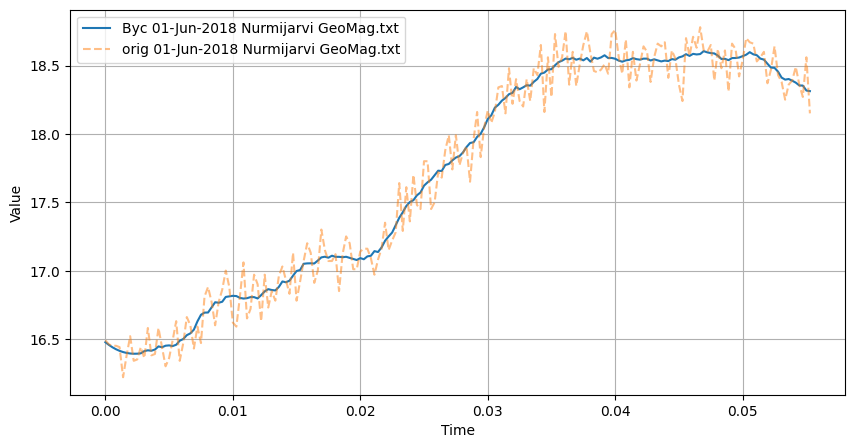

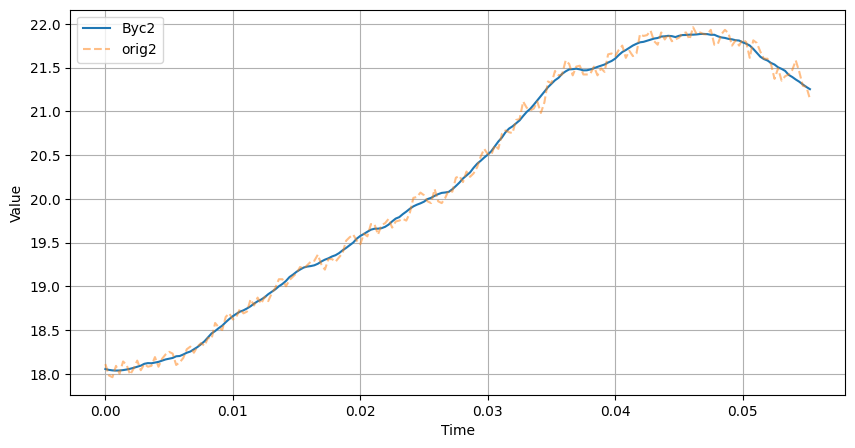

In [6]:
window_size = 21
ord = 3
if (True):
    h = df1.shape[0]
    orig_data1 = df1[col][:h]
    orig_data2 = df2[col][:h]
    df1[col] = savgol_filter(df1[col], window_length=window_size, polyorder=ord)
    df2[col] = savgol_filter(df2[col], window_length=window_size, polyorder=ord)
    # x = df1.Time[:h]
    # y = df1[col][:h]
    # gs = loess_smoothing(x, y, x, bandwidth=0.03 * (x.max() - x.min()), kernel='gaussian')

interval = slice(0, 200)
plt.figure(figsize=myfigsize)
plt.plot(df1.Time[interval], df1[col][interval], label=f'Byc {name1}')
plt.plot(df1.Time[interval], orig_data1[interval], label=f'orig {name1}', linestyle='--', alpha=0.5)
plot_setup()

plt.figure(figsize=myfigsize)
plt.plot(df2.Time[interval], df2[col][interval], label='Byc2')
plt.plot(df2.Time[interval], orig_data2[interval], label='orig2', linestyle='--', alpha=0.5)
plot_setup()

C:\Users\Admin\AppData\Local\Temp\ipykernel_23800\2755793409.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
C:\Users\Admin\AppData\Local\Temp\ipykernel_23800\2755793409.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


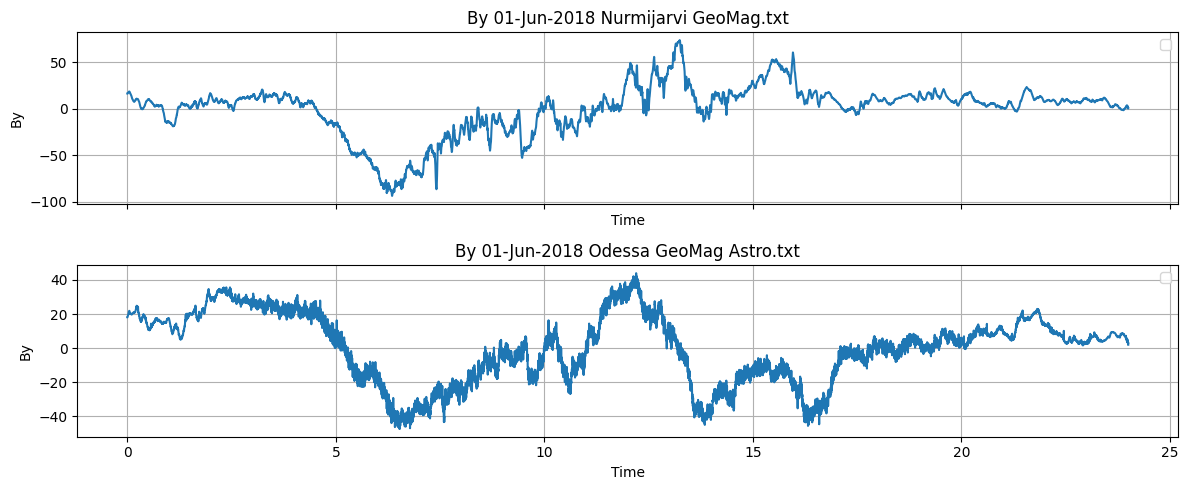

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

xxlabel = 'Time'
yylabel = 'By'
ttitle = f'By {name1}'
axs[0].plot(df1.Time, df1[col])
axs[0].grid()
axs[0].set_xlabel(xxlabel)
axs[0].set_ylabel(yylabel)
axs[0].set_title(ttitle)
axs[0].legend()

ttitle = f'By {name2}'
axs[1].plot(df2.Time, df2[col])
axs[1].grid()
axs[1].set_xlabel(xxlabel)
axs[1].set_ylabel(yylabel)
axs[1].set_title(ttitle)
axs[1].legend()

plt.tight_layout()
plt.show()


# FFT Filtrations

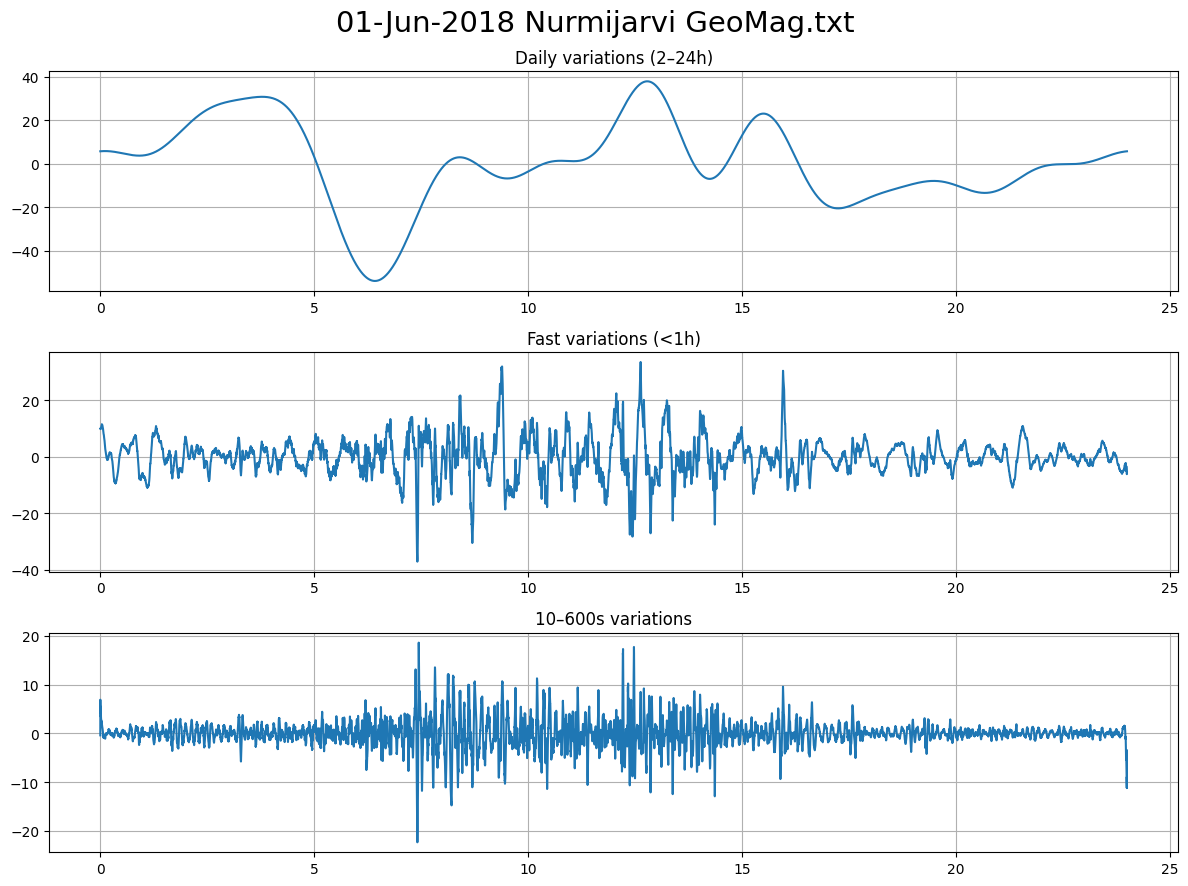

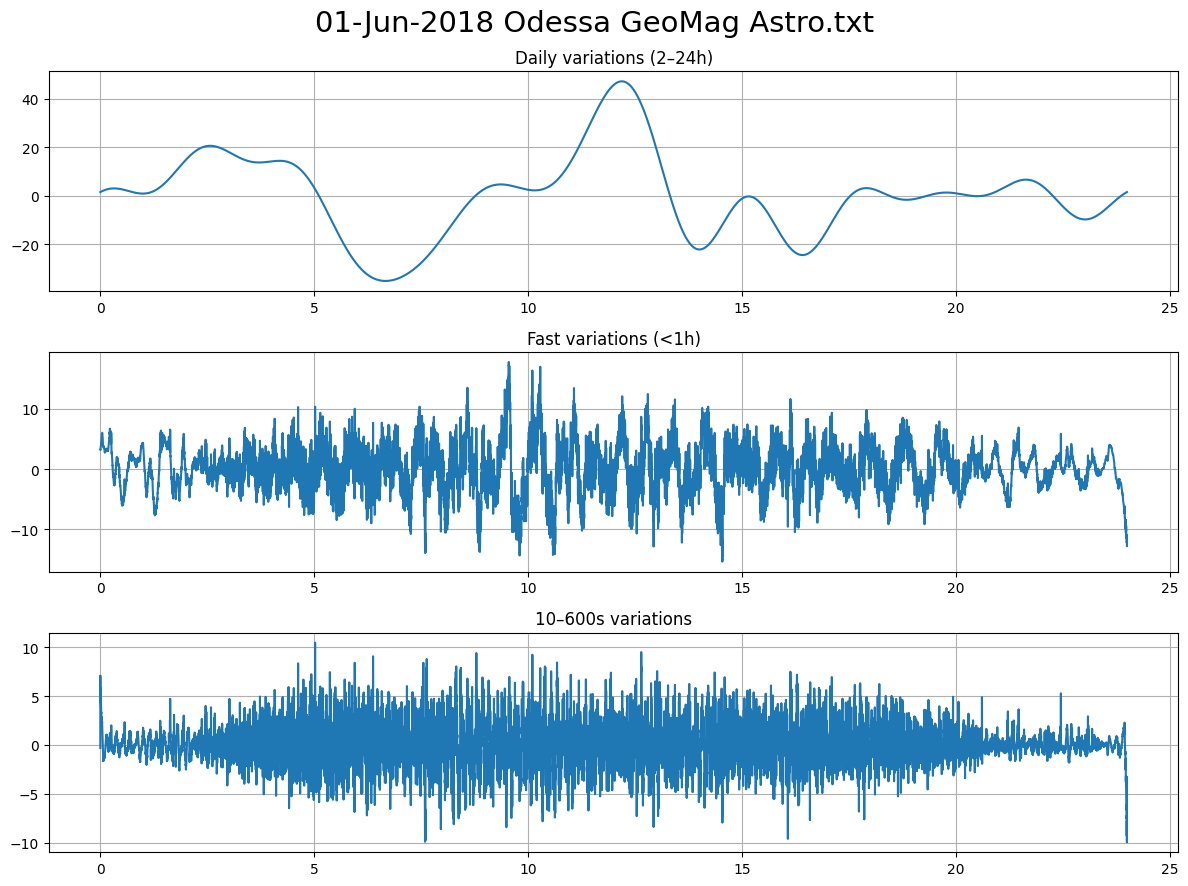

In [8]:
# folder = '01-June-2018'
map1 = fft_filters_plot(df1, figure=(12,9), title=name1, path=os.path.join('plots', folder, name1 + '_fft_filters.png'), save=False)
map2 = fft_filters_plot(df2, figure=(12,9), title=name2, path=os.path.join('plots', folder, name2 + '_fft_filters.png'), save=False)

# Wigner-Ville

In [74]:
sr = 5
interval = slice(1000, 60000)
domain1 = np.array(df1.Time)[interval][::sr]
# signal1 = np.array(df1[col])[::sr]
domain2 = np.array(df2.Time)[interval][::sr]
# signal2 = np.array(df2[col])[::sr]
val = {0: 'signal', 1: 'band', 2: 'fast', 3: 'daily'}
trueval = val[1]
signal1 = map1[trueval][interval][::sr]
signal2 = map2[trueval][interval][::sr]
print(signal1.shape, signal2.shape, domain1.shape, domain2.shape)

(11800,) (11800,) (11800,) (11800,)


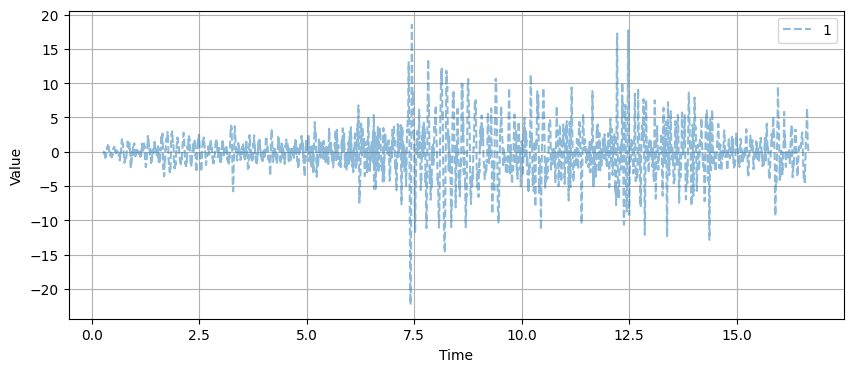

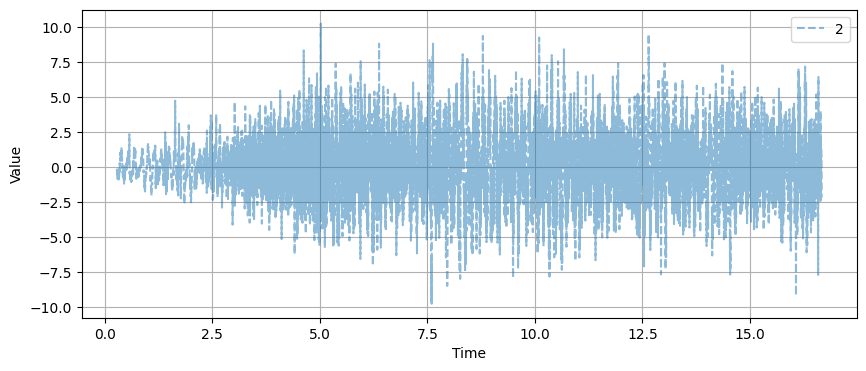

In [75]:
plt.figure(figsize=(10, 4))
plt.plot(domain1, signal1, label='1', linestyle='--', alpha=0.5)
plot_setup()
plt.figure(figsize=(10, 4))
plt.plot(domain2, signal2, label='2', linestyle='--', alpha=0.5)
plot_setup()

In [76]:
print(signal1.shape, signal2.shape, domain1.shape, domain2.shape)

(11800,) (11800,) (11800,) (11800,)


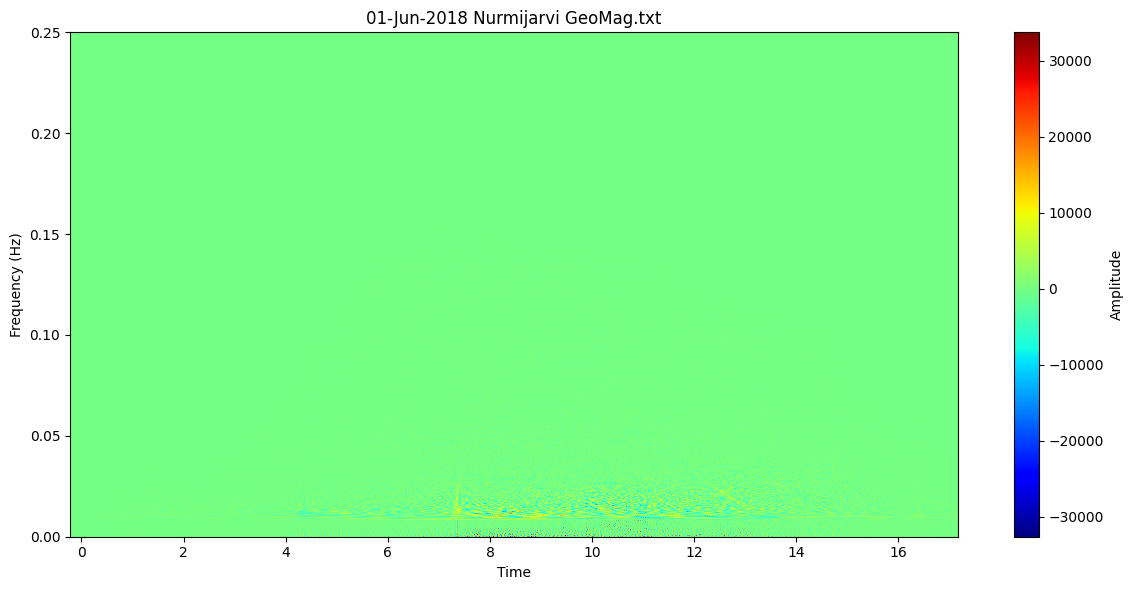

In [77]:
path = os.path.join('plots', folder, name1 + '_wvd.png')
_ = plot_wvd_positive(signal1, domain1, title=name1, path=path, save=False)
# path = os.path.join('plots', folder, name2 + '_wvd.png')
# _ = plot_wvd_positive(signal2, domain2, title=name2, path=path, save=False)

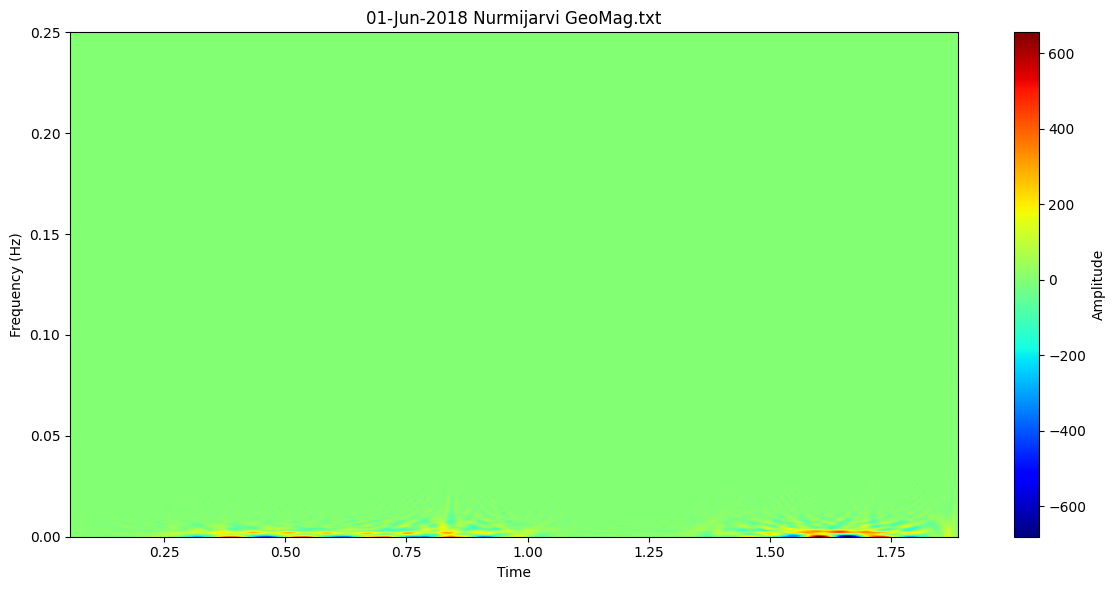

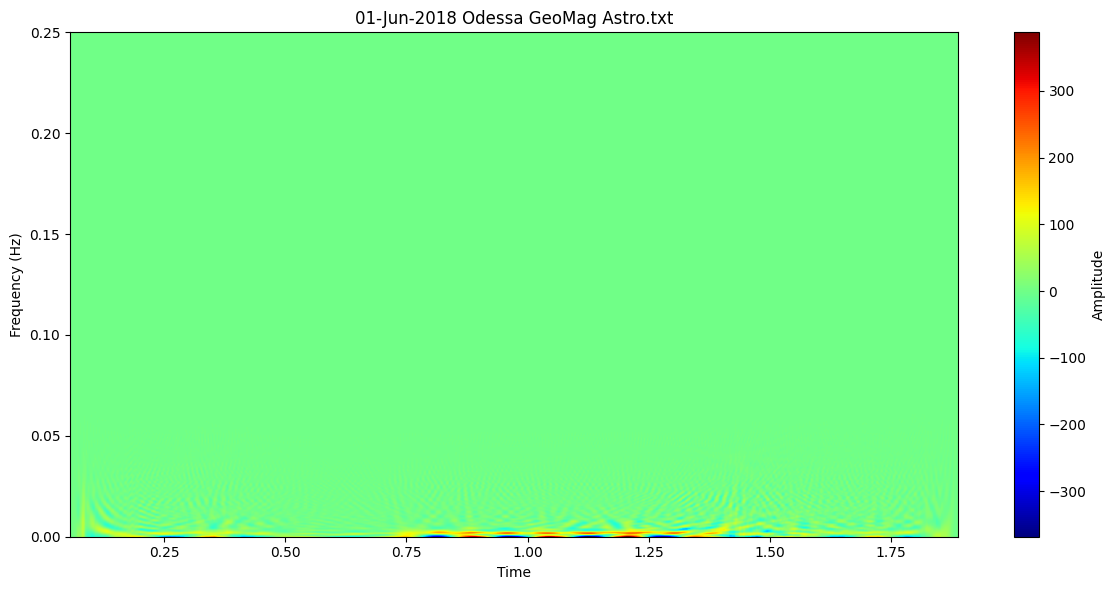

In [ ]:
_ = plot_pwvd_positive(signal1, domain1, title=name1)
_ = plot_pwvd_positive(signal2, domain2, title=name2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

def plot_wavelet_spectrogram(signal, timestamps, wavelet='morl', scales=None, dt=1.0, figsize=(12, 6), title=None, path=''):
    """
    Computes and plots a wavelet spectrogram (scalogram) of a signal.

    Parameters:
        signal (array-like): Input signal.
        timestamps (array-like): Time axis.
        wavelet (str): Wavelet name (e.g., 'morl', 'cmor', 'mexh', 'gaus', etc.).
        scales (array-like): Scales to use. If None, defaults are computed.
        dt (float): Sampling interval.
        figsize (tuple): Size of the plot.
        title (str): Title of the plot. If None, uses wavelet name.
    """
    if scales is None:
        max_scale = 128
        scales = np.arange(1, max_scale + 1)

    # Perform continuous wavelet transform
    coefficients, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=dt)

    # Power spectrum
    power = np.abs(coefficients) ** 2

    # Adjust title
    # if title is None:
    title = f"{title} using '{wavelet}'"

    timestamps = np.asanyarray(timestamps)
    # Plot
    plt.figure(figsize=figsize)
    extent = [timestamps[0], timestamps[-1], freqs[-1], freqs[0]]  # Flip freq axis
    plt.imshow(power, extent=extent, aspect='auto', cmap='jet')
    plt.colorbar(label='Power')
    plt.xlabel("Time")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path)

    plt.show()

    return power, freqs


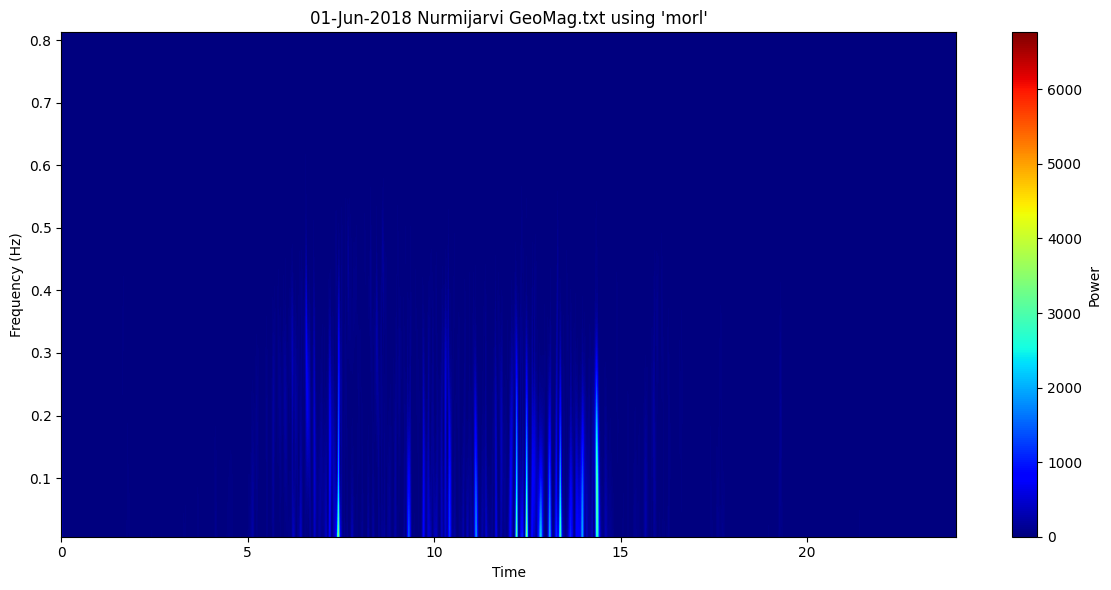

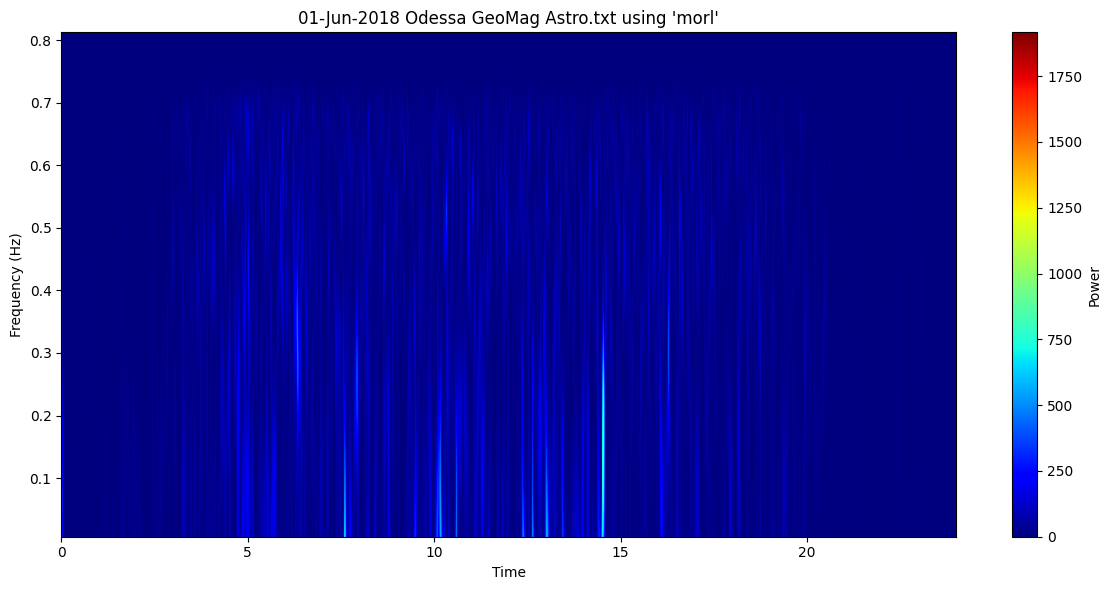

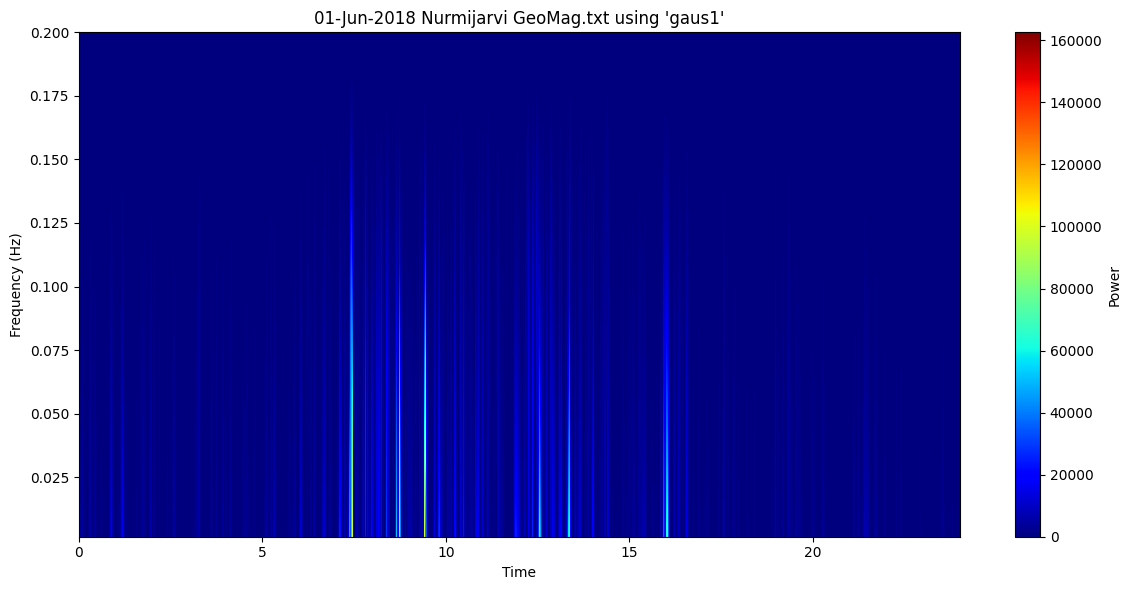

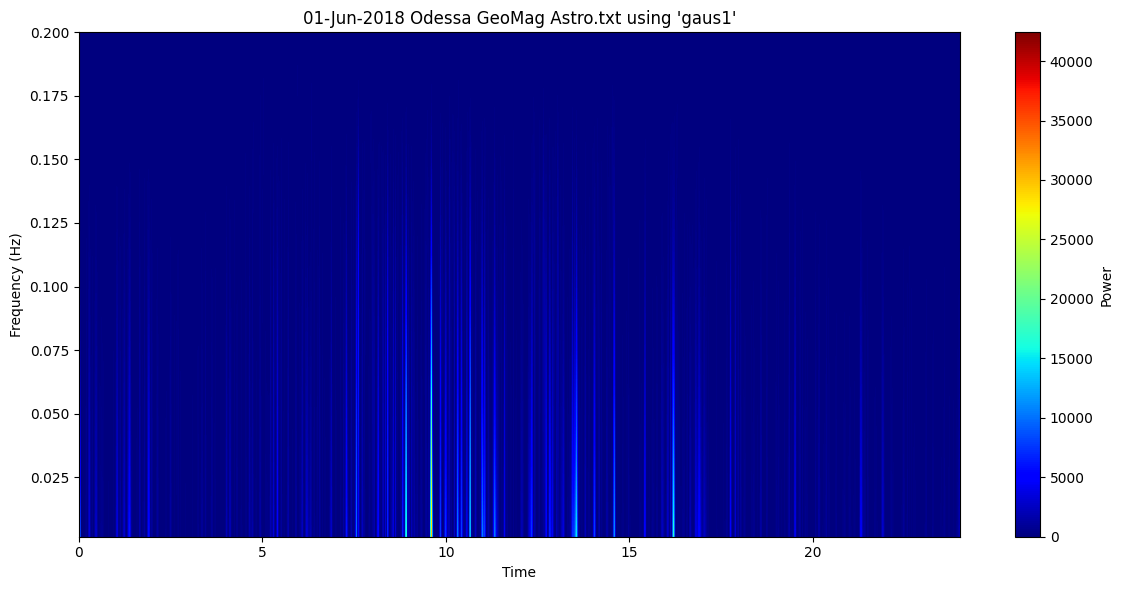

In [ ]:
# Example with Morlet wavelet

for type in ['morl', "gaus1"]:
    path1 = os.path.join('plots', folder, f'{name1}_wavelet_{type}.png')
    path2 = os.path.join('plots', folder, f'{name2}_wavelet_{type}.png')    
    power, freqs = plot_wavelet_spectrogram(df1[col], timestamps=df1.Time, wavelet=type, dt=1.0, title=name1, path=path1)
    power, freqs = plot_wavelet_spectrogram(df2[col], timestamps=df1.Time, wavelet=type, dt=1.0, title=name2, path=path2)



In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import savgol_filter

# from statsmodels.nonparametric.smoothers_lowess import lowess
# from scipy.stats import norm

# from utils.preprocessing import *
# from utils.plotting import plot_single, plot_setup
# from utils.filtrations import fft_filters_plot
# from utils.wignerville import *

# datelist = [
#     '01-Jun-2018',
#     '04-Nov-2018',
#     '05-Nov-2018',
#     '18-Jun-2018',
#     '18-Mar-2018',
#     '20-Apr-2018',
#     '23-Jun-2018',
#     '25-Aug-2018',
#     '26-Aug-2018',
#     '27-Feb-2018',
#     '05-Jan-2019',
# ]
# for folder in datelist:
#     os.makedirs(f'./plots/{folder}', exist_ok=True)
#     name1 = f'{folder} Nurmijarvi GeoMag.txt'
#     name2 = f'{folder} Odessa GeoMag Astro.txt'

#     # name1 = '01-Jun-2018 Nurmijarvi GeoMag.txt'
#     # name2 = '01-Jun-2018 Odessa GeoMag Astro.txt'
#     df1 = load_data(f'./data/GeoMag Odessa-Finland/{name1}')
#     df2 = load_data(f'./data/GeoMag Odessa-Finland/{name2}')
    
#     name1 = name1[:-4]
#     name2 = name2[:-4]
    
#     print(df1.shape, df2.shape)

#     col = 'Byc'
#     myfigsize = (10, 5)
#     mfs = (10, 10)
#     df1 = drop_value(df1, 'By')
#     df2 = drop_value(df2, 'By')
#     df1[col] = center_data(df1.By)
#     df2[col] = center_data(df2.By)

#     def tricube_weight(d, bandwidth):
#         """Tricube kernel function."""
#         u = np.abs(d / bandwidth)
#         return (1 - u**3)**3 * (u < 1)

#     def gaussian_weight(d, bandwidth):
#         """Gaussian kernel function."""
#         return np.exp(-0.5 * (d / bandwidth)**2)

#     def loess_smoothing(x, y, x_eval, bandwidth=1, kernel='tricube', degree=1):
#         y_smooth = np.zeros_like(x_eval)

#         for i, x0 in enumerate(x_eval):
#             distances = np.abs(x - x0)
            
#             if kernel == 'tricube':
#                 weights = tricube_weight(distances, bandwidth)
#             elif kernel == 'gaussian':
#                 weights = gaussian_weight(distances, bandwidth)
#             else:
#                 raise ValueError("Unknown kernel")

#             W = np.diag(weights)
#             X_mat = np.vstack([x**p for p in range(degree + 1)]).T
#             XTWX = X_mat.T @ W @ X_mat
#             XTWY = X_mat.T @ W @ y

#             theta = np.linalg.pinv(XTWX) @ XTWY  # Solve weighted least squares
#             y_smooth[i] = sum(theta[p] * x0**p for p in range(degree + 1))

#         return y_smooth

#     window_size = 21
#     ord = 3
#     if (True):
#         h = df1.shape[0]
#         orig_data1 = df1[col][:h]
#         orig_data2 = df2[col][:h]
#         df1[col] = savgol_filter(df1[col], window_length=window_size, polyorder=ord)
#         df2[col] = savgol_filter(df2[col], window_length=window_size, polyorder=ord)
#         # x = df1.Time[:h]
#         # y = df1[col][:h]
#         # gs = loess_smoothing(x, y, x, bandwidth=0.03 * (x.max() - x.min()), kernel='gaussian')

#     interval = slice(0, 200)
#     plt.figure(figsize=myfigsize)
#     plt.plot(df1.Time[interval], df1[col][interval], label=f'Byc {name1}')
#     plt.plot(df1.Time[interval], orig_data1[interval], label=f'orig {name1}', linestyle='--', alpha=0.5)
#     plot_setup()

#     plt.figure(figsize=myfigsize)
#     plt.plot(df2.Time[interval], df2[col][interval], label='Byc2')
#     plt.plot(df2.Time[interval], orig_data2[interval], label='orig2', linestyle='--', alpha=0.5)
#     plot_setup()

#     plt.figure(figsize=myfigsize)
#     plt.plot(df1.Time, df1[col])
#     plot_setup(title=name1)

#     plt.figure(figsize=myfigsize)
#     plt.plot(df2.Time, df2[col])
#     plot_setup(title=name2)

#     # folder = '01-June-2018'
#     fft_filters_plot(df1, figure=(12,9), title=name1, path=os.path.join('plots', folder, name1 + '_fft_filters.png'))
#     _ = fft_filters_plot(df2, figure=(12,9), title=name2, path=os.path.join('plots', folder, name2 + '_fft_filters.png'))

#     sr = 200
#     domain1 = np.array(df1.Time)[::sr]
#     signal1 = np.array(df1[col])[::sr]
#     domain2 = np.array(df2.Time)[::sr]
#     signal2 = np.array(df2[col])[::sr]

#     path = os.path.join('plots', folder, name1 + '_wvd.png')
#     _ = plot_wvd_positive(signal1, domain1, title=name1, path=path)
#     path = os.path.join('plots', folder, name2 + '_wvd.png')
#     _ = plot_wvd_positive(signal2, domain2, title=name2, path=path)

#     _ = plot_pwvd_positive(signal1, domain1, title=name1)
#     _ = plot_pwvd_positive(signal2, domain2, title=name2)

#     import numpy as np
#     import matplotlib.pyplot as plt
#     import pywt

#     def plot_wavelet_spectrogram(signal, timestamps, wavelet='morl', scales=None, dt=1.0, figsize=(12, 6), title=None, path=''):
#         """
#         Computes and plots a wavelet spectrogram (scalogram) of a signal.

#         Parameters:
#             signal (array-like): Input signal.
#             timestamps (array-like): Time axis.
#             wavelet (str): Wavelet name (e.g., 'morl', 'cmor', 'mexh', 'gaus', etc.).
#             scales (array-like): Scales to use. If None, defaults are computed.
#             dt (float): Sampling interval.
#             figsize (tuple): Size of the plot.
#             title (str): Title of the plot. If None, uses wavelet name.
#         """
#         if scales is None:
#             max_scale = 128
#             scales = np.arange(1, max_scale + 1)

#         # Perform continuous wavelet transform
#         coefficients, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=dt)

#         # Power spectrum
#         power = np.abs(coefficients) ** 2

#         # Adjust title
#         # if title is None:
#         title = f"{title} using '{wavelet}'"

#         timestamps = np.asanyarray(timestamps)
#         # Plot
#         plt.figure(figsize=figsize)
#         extent = [timestamps[0], timestamps[-1], freqs[-1], freqs[0]]  # Flip freq axis
#         plt.imshow(power, extent=extent, aspect='auto', cmap='jet')
#         plt.colorbar(label='Power')
#         plt.xlabel("Time")
#         plt.ylabel("Frequency (Hz)")
#         plt.title(title)
#         plt.tight_layout()
#         plt.savefig(path)

#         plt.show()

#         return power, freqs
#     # Example with Morlet wavelet

#     for type in ['morl', "gaus1"]:
#         path1 = os.path.join('plots', folder, f'{name1}_wavelet_{type}.png')
#         path2 = os.path.join('plots', folder, f'{name2}_wavelet_{type}.png')    
#         power, freqs = plot_wavelet_spectrogram(df1[col], timestamps=df1.Time, wavelet=type, dt=1.0, title=name1, path=path1)
#         power, freqs = plot_wavelet_spectrogram(df2[col], timestamps=df1.Time, wavelet=type, dt=1.0, title=name2, path=path2)

